In [1]:
import numpy as np
from matplotlib import pyplot as plt

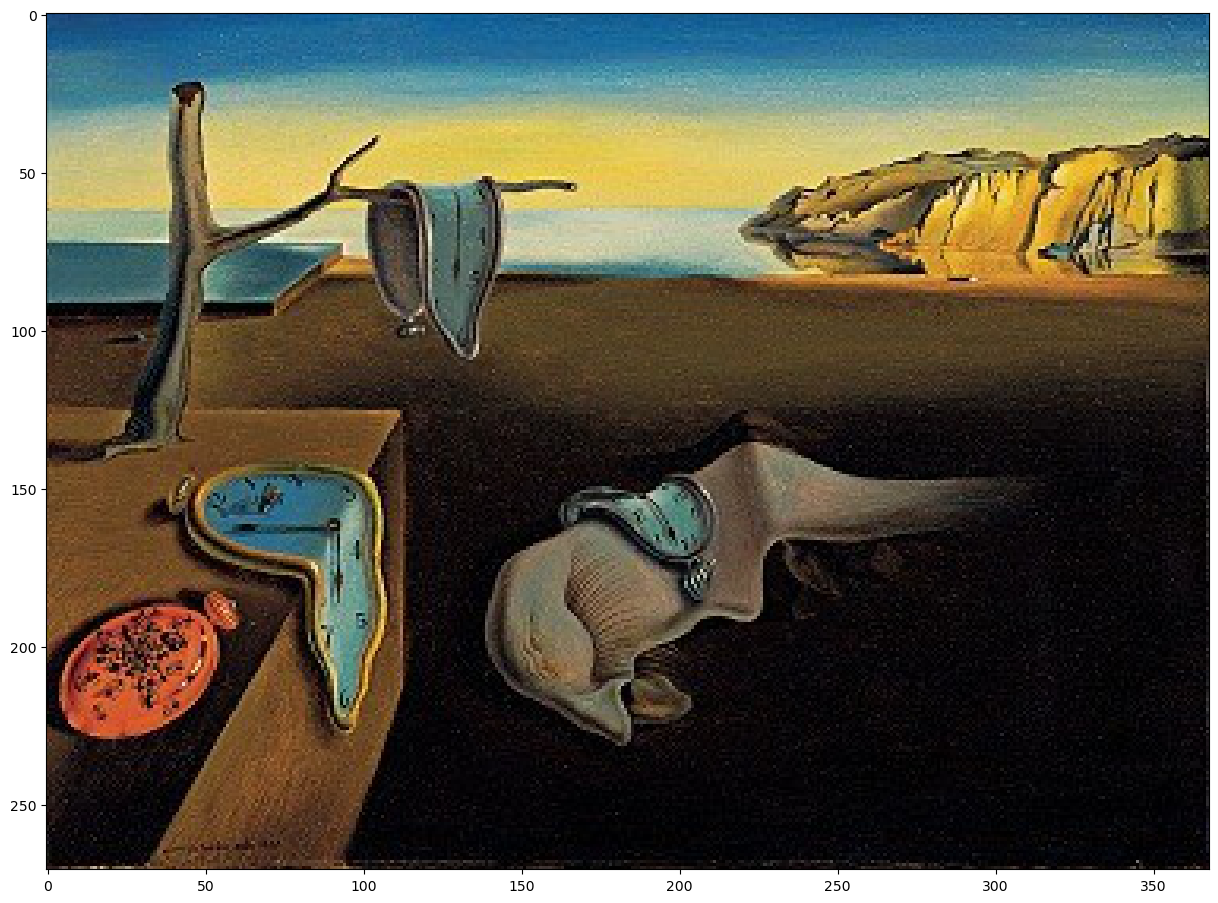

In [2]:
figsize = (15,15) # for matplotlib picture plot size

img = plt.imread('The_Persistence_of_Memory.jpg')
# img = plt.imread('1ef7eb3c08cf50e64691e3d2d0a67c31.jpg')

plt.subplots(1, figsize=figsize)
plt.imshow(img)

## Greyscaling of image

In [3]:
def GreyScale(img):
    greyImg = [[0 for x in range(len(img[0]))] for y in range(len(img))] 
    for y in range(len(img)):
        for x in range(len(img[0])):
            R = img[y][x][0]/255
            G = img[y][x][1]/255
            B = img[y][x][2]/255
            gamma = 2.2
            Clin = .2126 * pow(R,gamma) + .7152 * pow(G,gamma) + .0722 * pow(B,gamma)
            Csrgb = 0
            if Clin <=0.0031308:
                Csrgb = 12.92 * Clin
            else:
                Csrgb = 1.055 * pow(Clin,1/2.4)-0.055
            greyImg[y][x] = Csrgb
    return greyImg

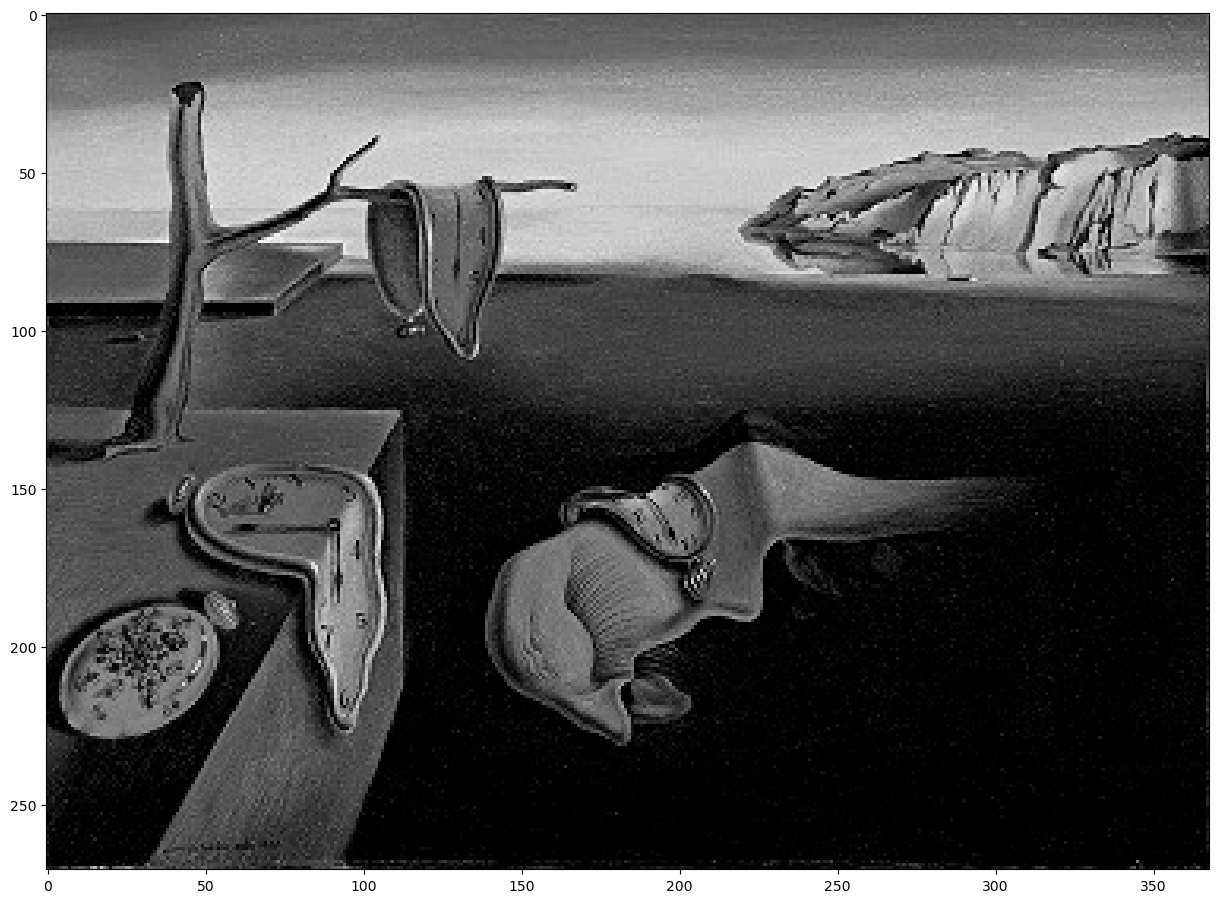

In [4]:
greyImg = GreyScale(img)
plt.subplots(1, figsize=figsize)
plt.imshow(greyImg,cmap='gray',vmin = 0,vmax =1)

## Find Eges

In [5]:
sobelX = [
    [-0.125,0.0,0.125],
    [-0.25,0.0,0.25],
    [-0.125,0.0,0.125]
]
sobelY = [
    [-0.125,-0.25,-0.125],
    [0.0,0.0,0.0],
    [0.125,0.25,0.125]
]



# use these kernels for harder edges 
sobelX2 = [
    [1,0.0,-1],
    [2,0.0,-2],
    [1,0.0,-1]
]
    
sobelY2 = [
    [1,2,1],
    [0.0,0.0,0.0],
    [-1,-2,-1]
]

# only working for 3x3 size kernel
def imageKernel(img,kernel):
    xSize = len(img[0])
    ySize = len(img)
    resImg = [[0 for x in range(xSize)] for y in range(ySize)] 
    for y in range(ySize):
        for x in range(xSize):
            res = 0
            # 3x3 kernel
            for i in range(3):
                for j in range(3):
                    if y-1+i == 0 or y-1+i == ySize or x-1+j == 0 or x-1+j == xSize:
                        continue
                    res += kernel[i][j] * img[y-1+i][x-1+j]
            resImg[y][x] =res
    return resImg


### Edges in X direction

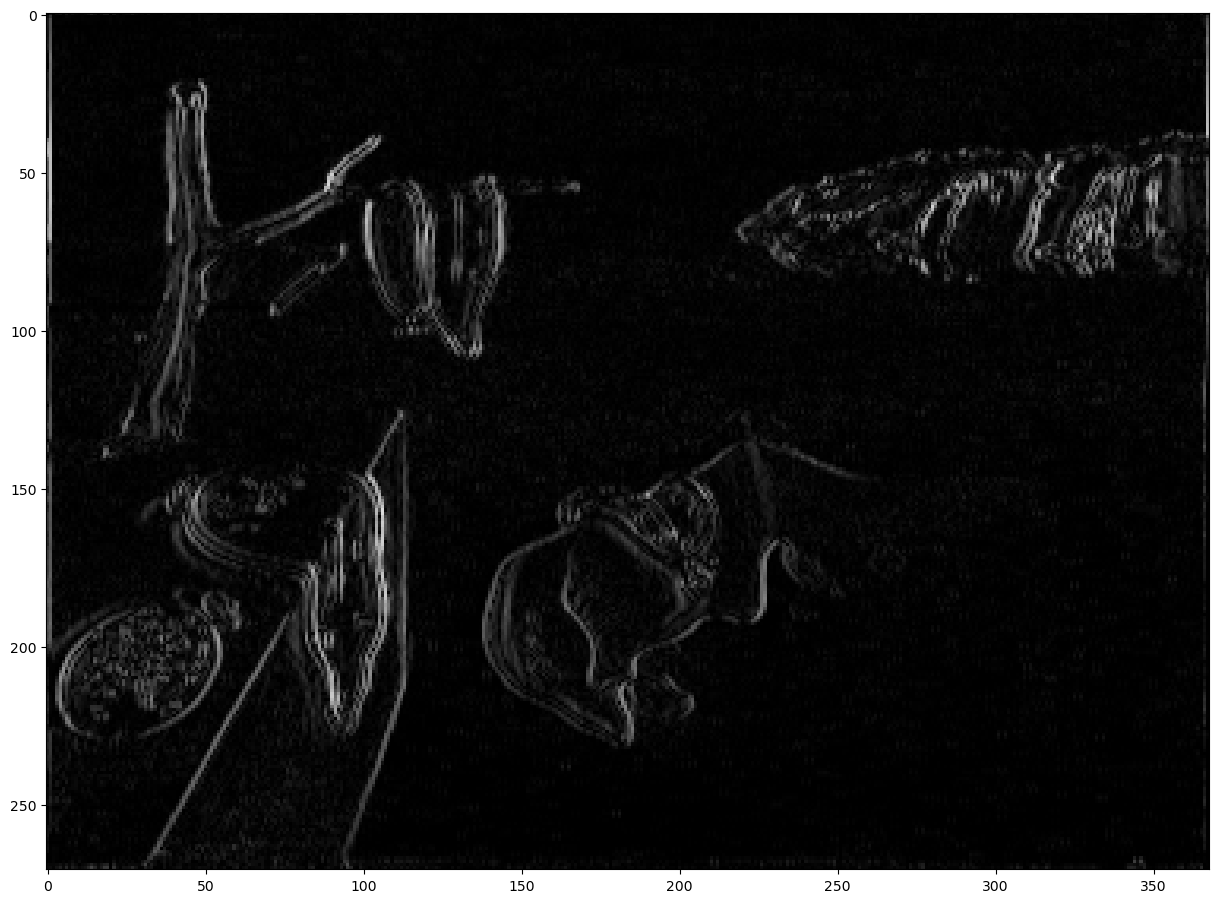

In [6]:
sobelXImg = imageKernel(greyImg,sobelX)
sobelXImg = np.abs(np.array(sobelXImg))
plt.subplots(1, figsize=figsize)
plt.imshow(sobelXImg,cmap='gray',vmin = 0,vmax =0.5)

### Edges in Y direction

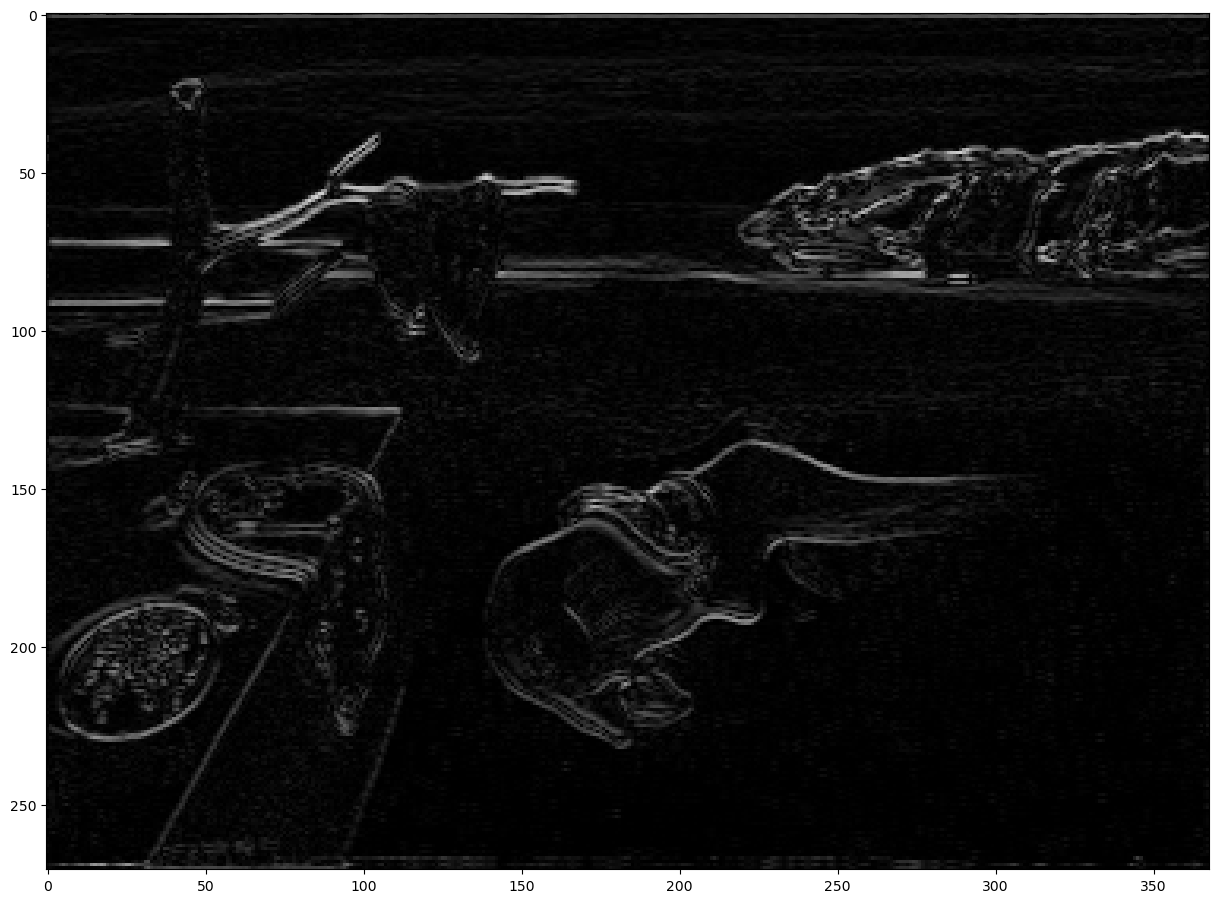

In [7]:
sobelYImg = imageKernel(greyImg,sobelY)
sobelYImg = np.abs(np.array(sobelYImg))
plt.subplots(1, figsize=figsize)
plt.imshow(sobelYImg,cmap='gray',vmin = 0,vmax =0.5)

### Add Both edge images

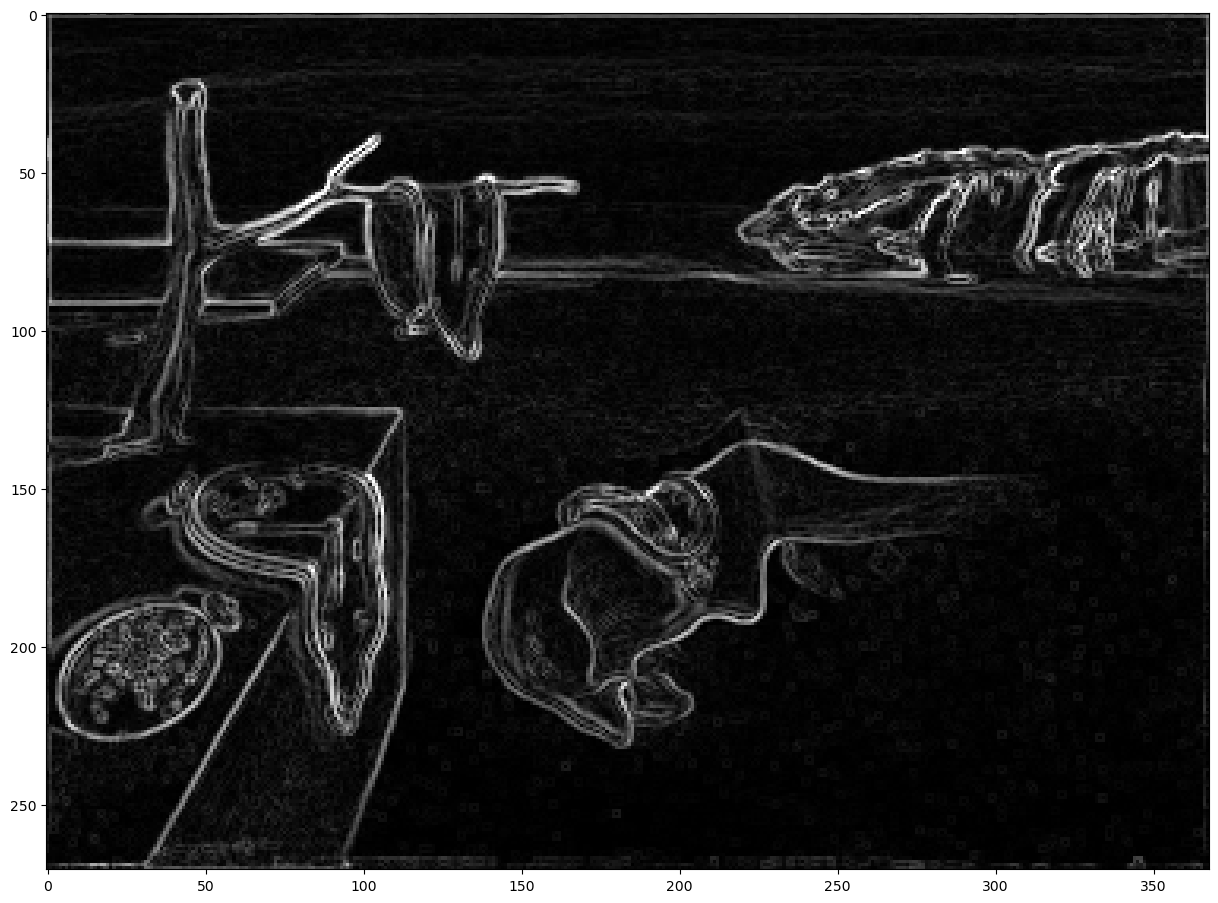

In [8]:
sobelXYImg =  np.array(sobelXImg) + np.array(sobelYImg)
# sobelXYImg = sobelXYImg/2 # maybe scale img
plt.subplots(1, figsize=figsize)
plt.imshow(sobelXYImg,cmap='gray',vmin = 0,vmax =.5)

## Find Path

In [9]:
def greedyPath(image):
    height, width = image.shape[:2]
    minVal = image[0].argmin()
    path = [minVal]
    for y in range(1,height):
        lastPosX = path[y-1]
        nextValues = []
        # left
        if lastPosX > 0:
            nextValues.append(image[y][lastPosX-1])
        # mid
        nextValues.append(image[y][lastPosX])
        # right
        if lastPosX < width-1:
            nextValues.append(image[y][lastPosX+1])
        # find smallest
        minVal = np.argmin(nextValues)
        path.append(minVal+lastPosX-1)
    return path

In [10]:
def DEBUG_PrintImageWithPath(image,path):
    xSize = len(image[0])
    ySize = len(image)
    resImg = [[0 for x in range(xSize)] for y in range(ySize)] 
    for y in range(ySize):
        for x in range(xSize):
            if path[y] == x:
                resImg[y][x] = [255,255,255]
            else:
                resImg[y][x] = image[y][x]
    plt.subplots(1, figsize=figsize)
    plt.imshow(resImg)
    # return resImg

In [11]:
def DEBUG_removeMinus(image):
    xSize = len(image[0])
    ySize = len(image)
    newImage = [[0 for x in range(xSize)] for y in range(ySize)] 
    for y in range(ySize):
        for x in range(xSize):
            if image[y][x] < 0:
                newImage[y][x] = abs(image[y][x])
            else:
                newImage[y][x] = abs(image[y][x])
    return newImage

In [12]:
def getEnergyMap(image):
    ySize, xSize = image.shape[:2]
    energyMap = np.zeros(image.shape)
    
    # lowest row   
    energyMap[0] = image[0]
    
    # from bottom to top
    for y in reversed(range(ySize-1)):
        for x in range(xSize):
            # middle
            best = energyMap[y+1][x]
            # left
            if x>0:
                if energyMap[y+1][x-1] < best:
                    best = energyMap[y+1][x-1]
            #right
            if x<xSize-1:
                if energyMap[y+1][x+1] < best:
                    best = energyMap[y+1][x+1]
                
            energyMap[y][x] = best + image[y][x]
    return energyMap

In [13]:
def deletePath(image,path):
    xSize = len(image[0])
    ySize = len(image)
    newImage = [[0 for x in range(xSize-1)] for y in range(ySize)] 
    for y in range(ySize):
        nx = -1
        for x in range(xSize-1):
            nx+=1
            if path[y] == nx:
                nx +=1
            newImage[y][x] = image[y][nx]
    return newImage

### Print EnergyMap of image

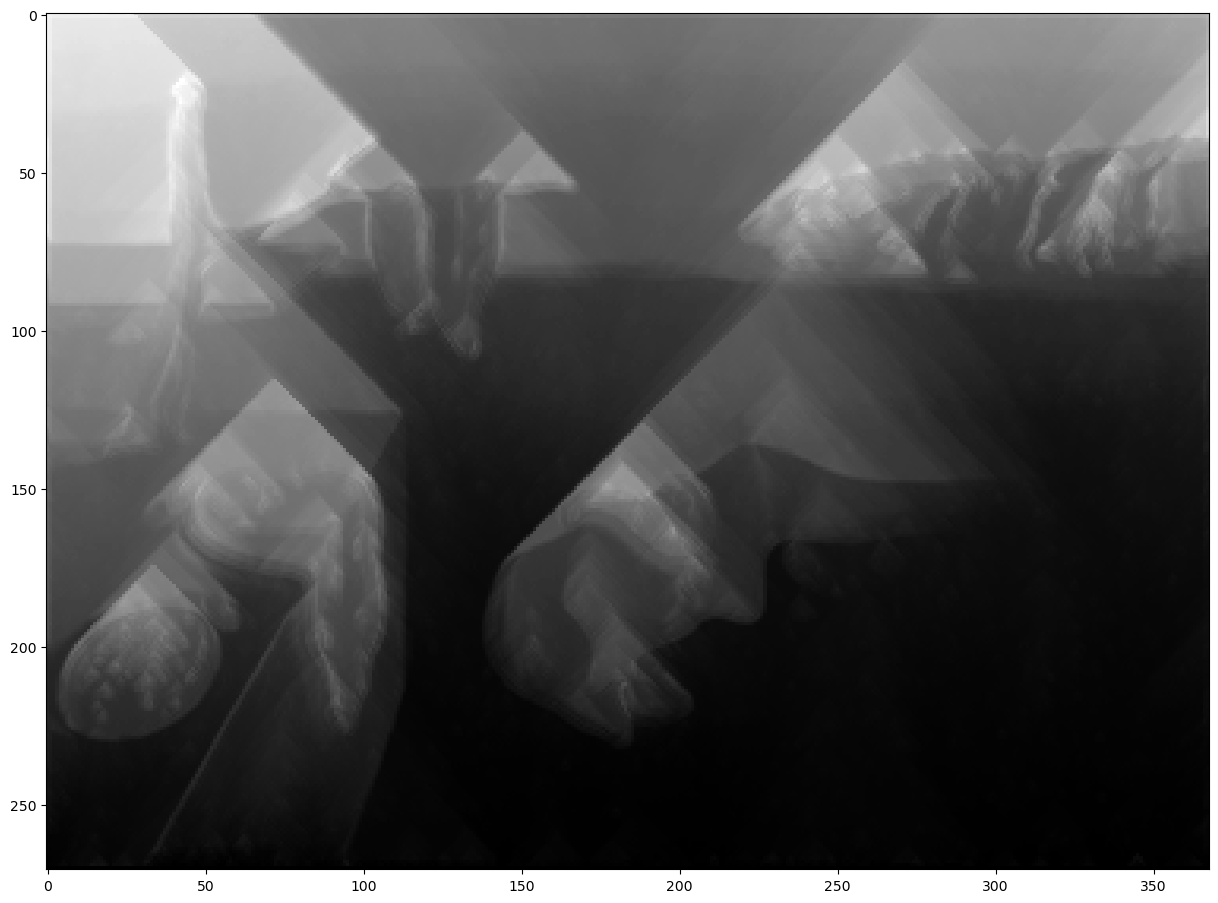

In [14]:
energyMap = getEnergyMap(np.abs(np.array(sobelXYImg)))
plt.subplots(1, figsize=figsize)
plt.imshow(energyMap,cmap='gray',vmin = 0,vmax =5)

### Greedy Path Version

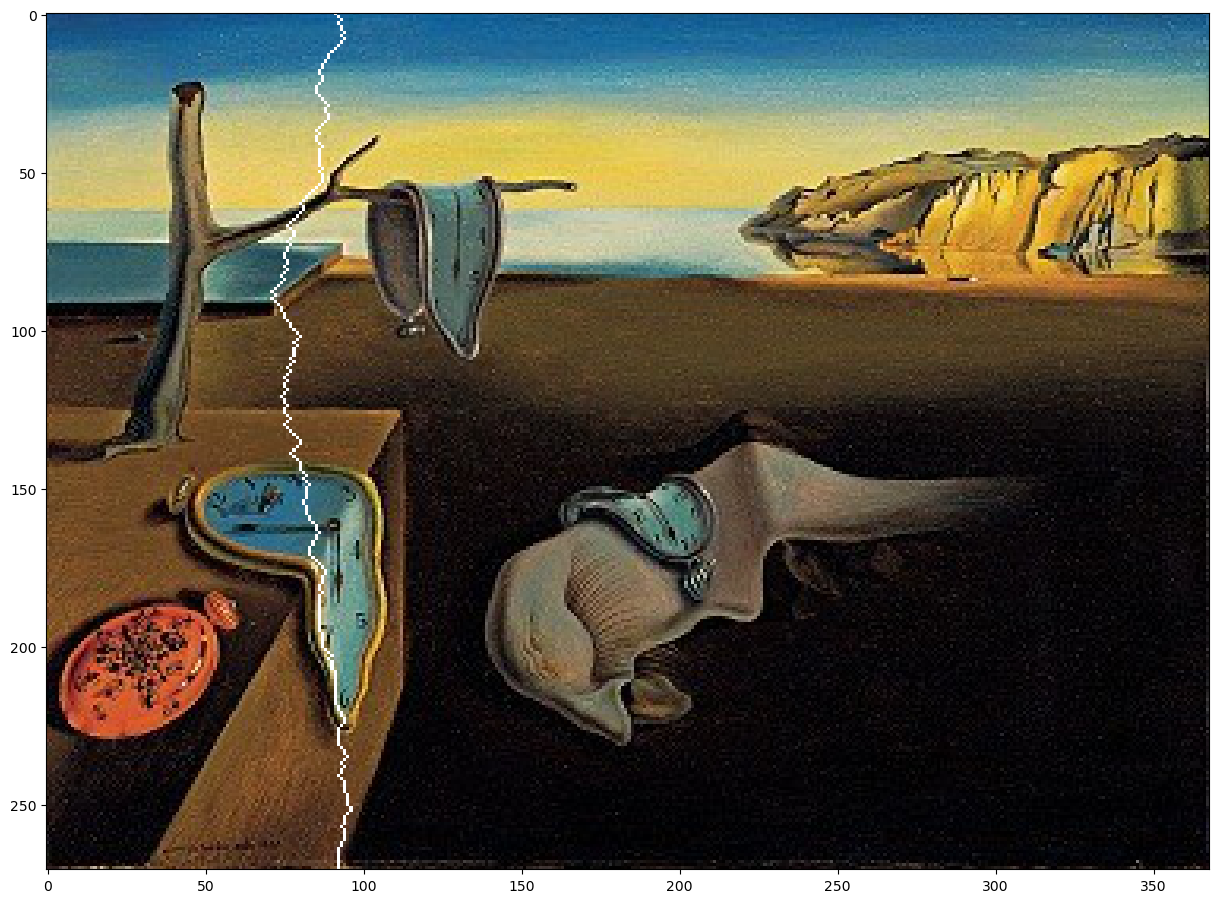

In [15]:
greedPath = greedyPath(sobelXYImg)
DEBUG_PrintImageWithPath(img,greedPath)

### Energy Path Version

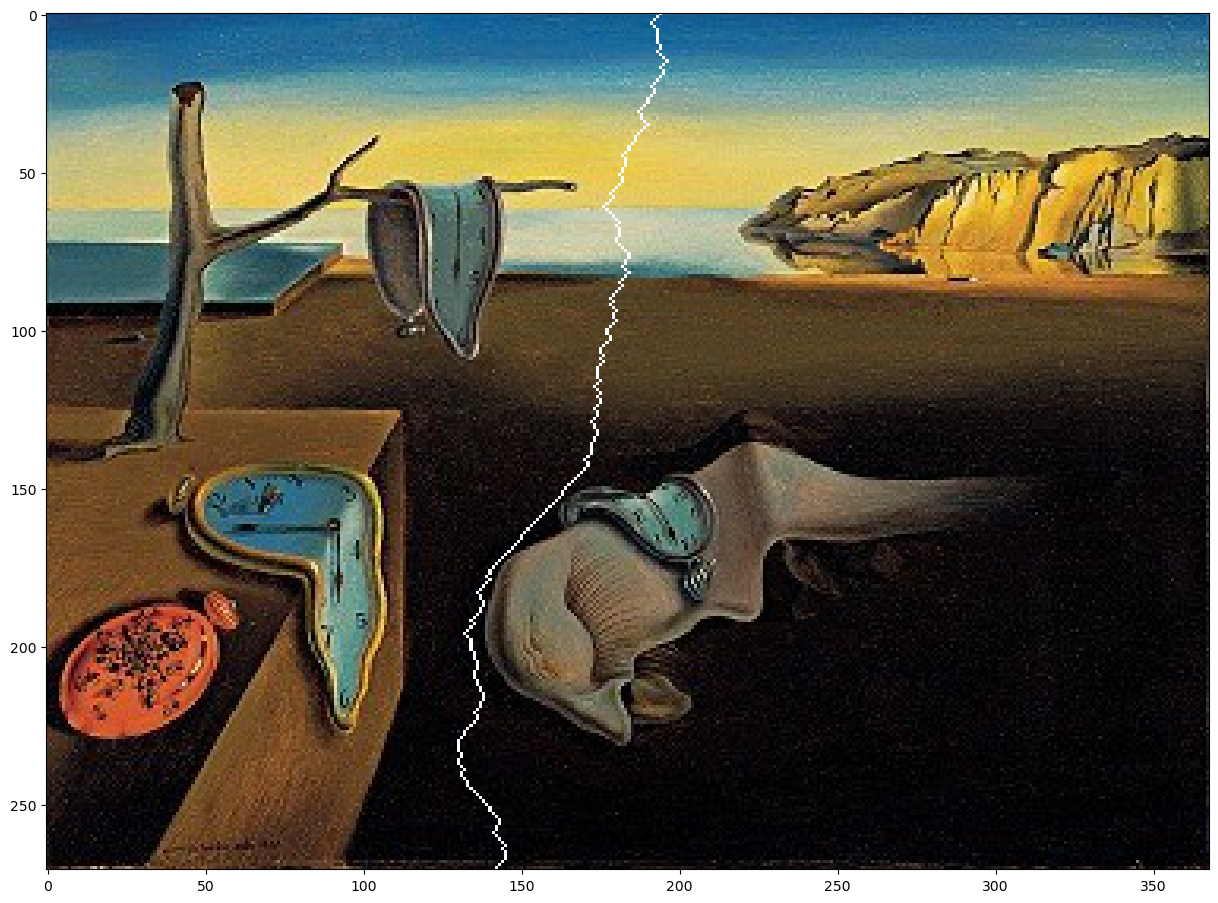

In [16]:
greedPath = greedyPath(energyMap)
pathImg = DEBUG_PrintImageWithPath(img,greedPath)

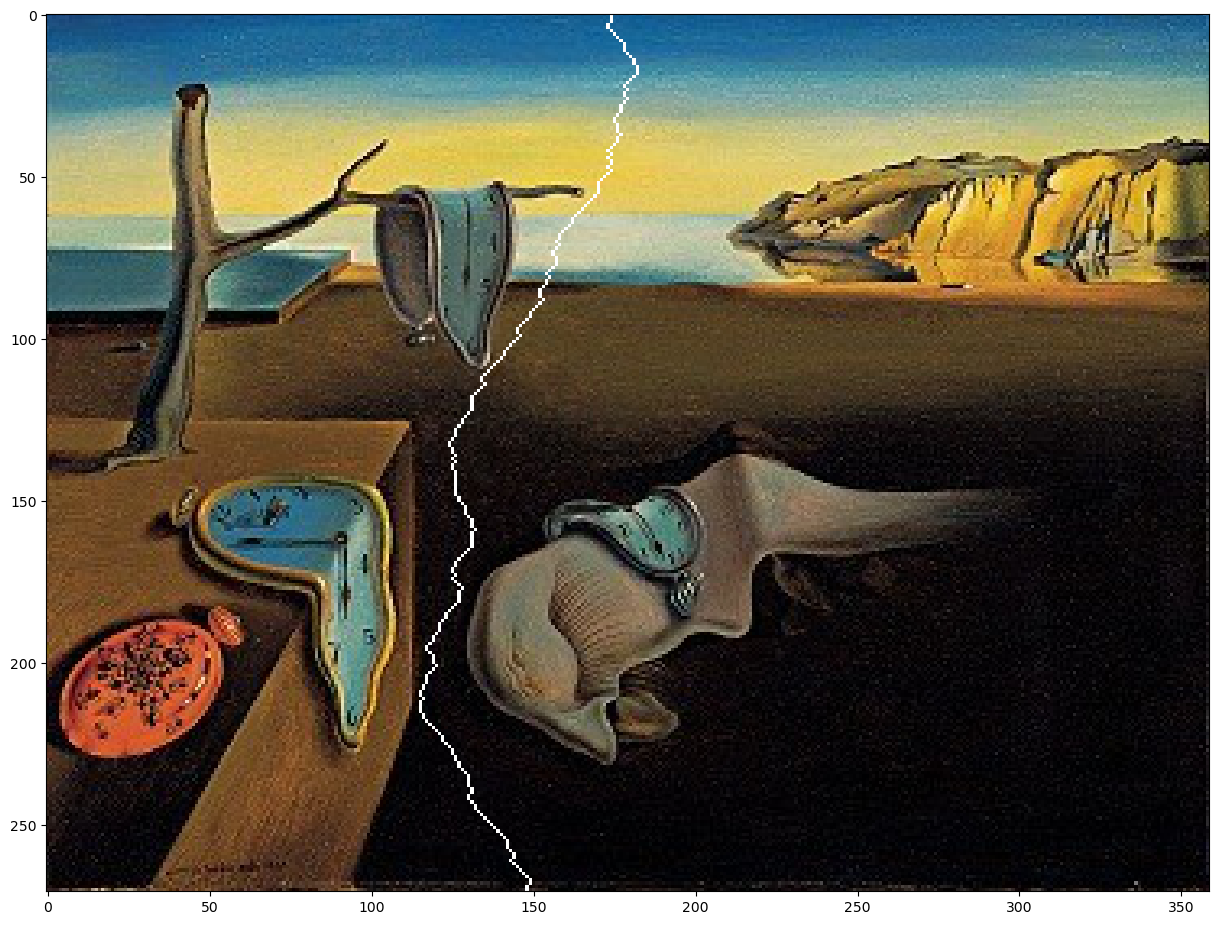

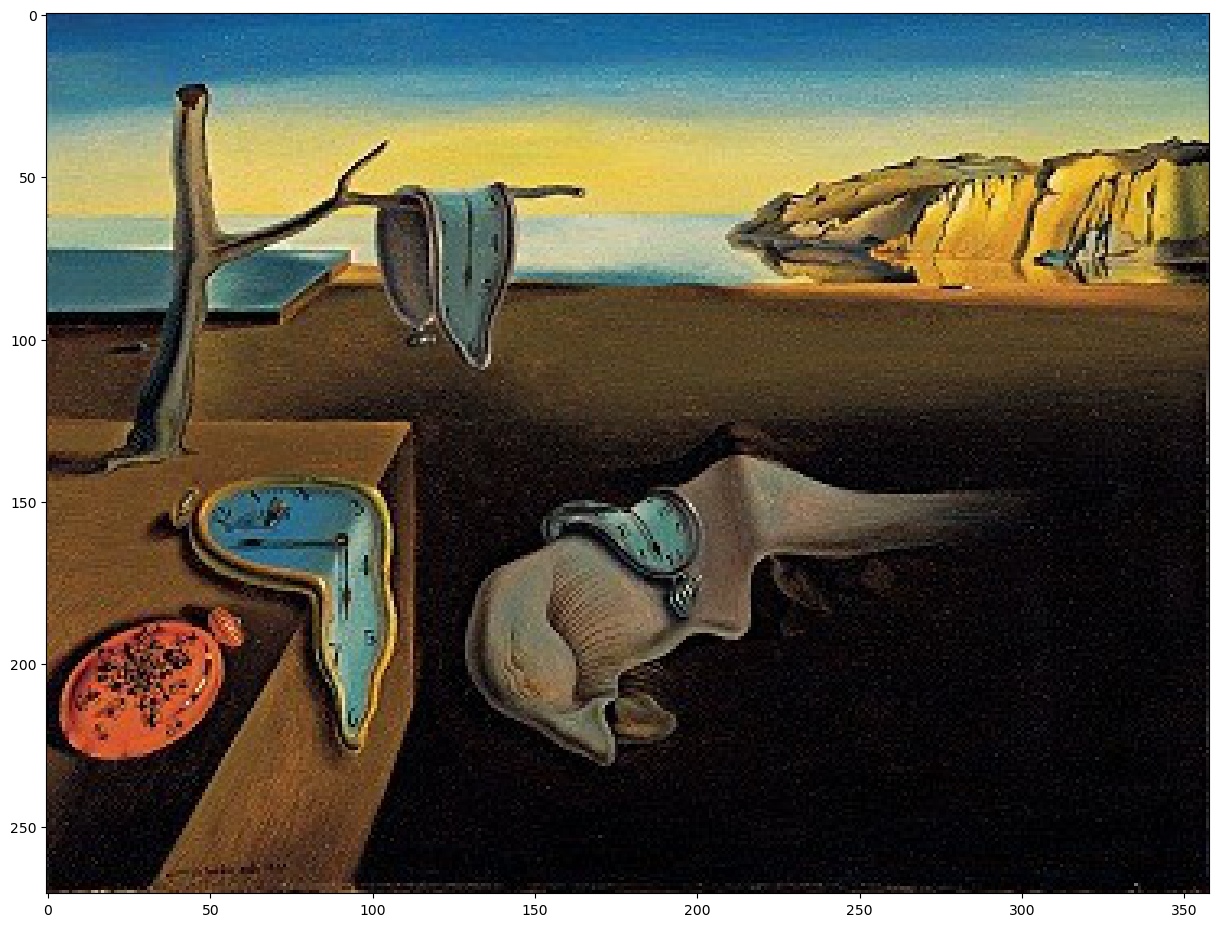

In [17]:
N = 10
origImg = img
for i in range(N):
    origGreyImg = GreyScale(origImg)
    XImg = imageKernel(origGreyImg,sobelX)
    YImg = imageKernel(origGreyImg,sobelY)
    XYIMG = XImg + YImg
    XYIMG = np.abs(XYIMG)
    ener = getEnergyMap(XYIMG)
    pathDEBUG = greedyPath(ener)
    if i == N-1:
        DEBUG_PrintImageWithPath(origImg,pathDEBUG)
    origImg = deletePath(origImg,pathDEBUG)

plt.subplots(1, figsize=figsize)
plt.imshow(origImg,vmin = 0,vmax =1)



### Original Image

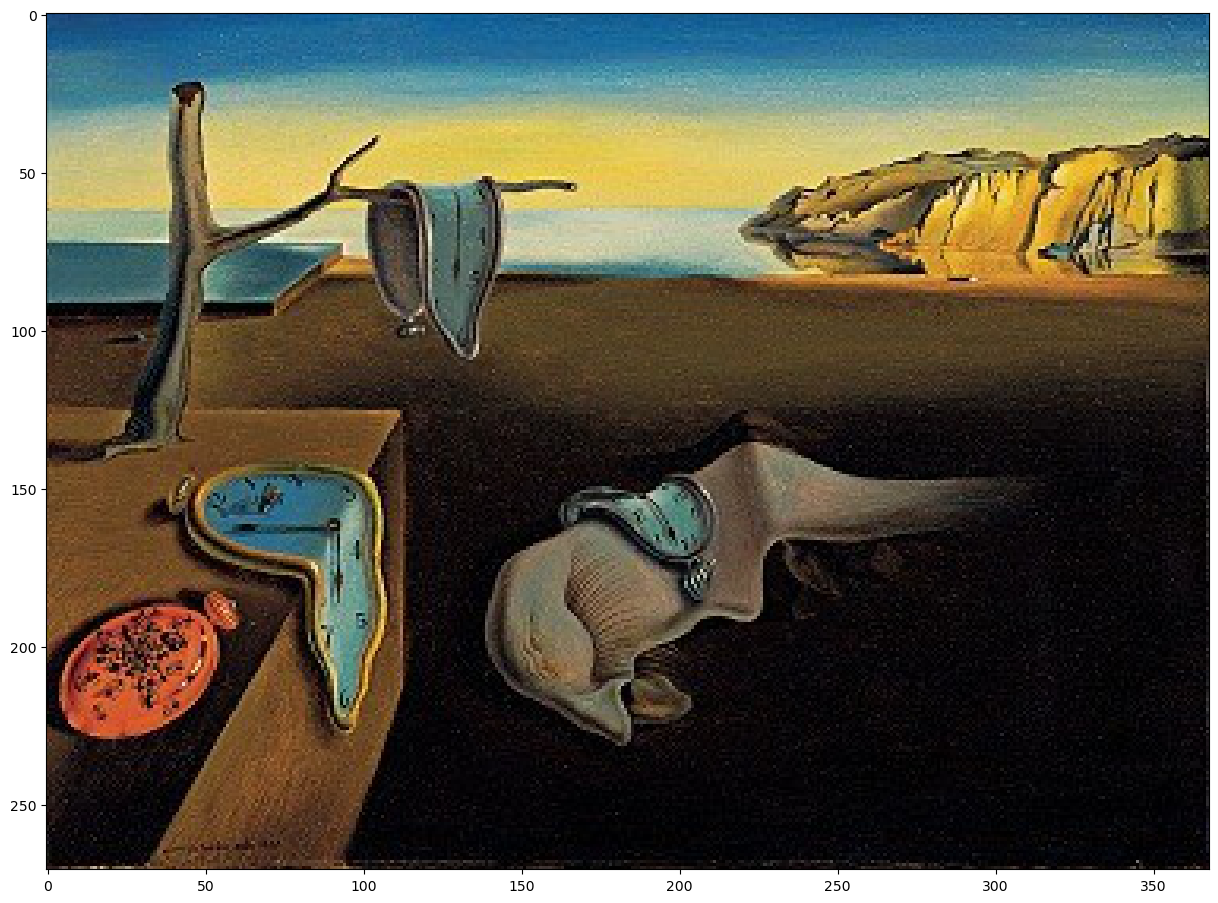

In [18]:
plt.subplots(1, figsize=figsize)
plt.imshow(img,vmin = 0,vmax =1)

We can only calculate Greyscale an the kernel once and reuse the data

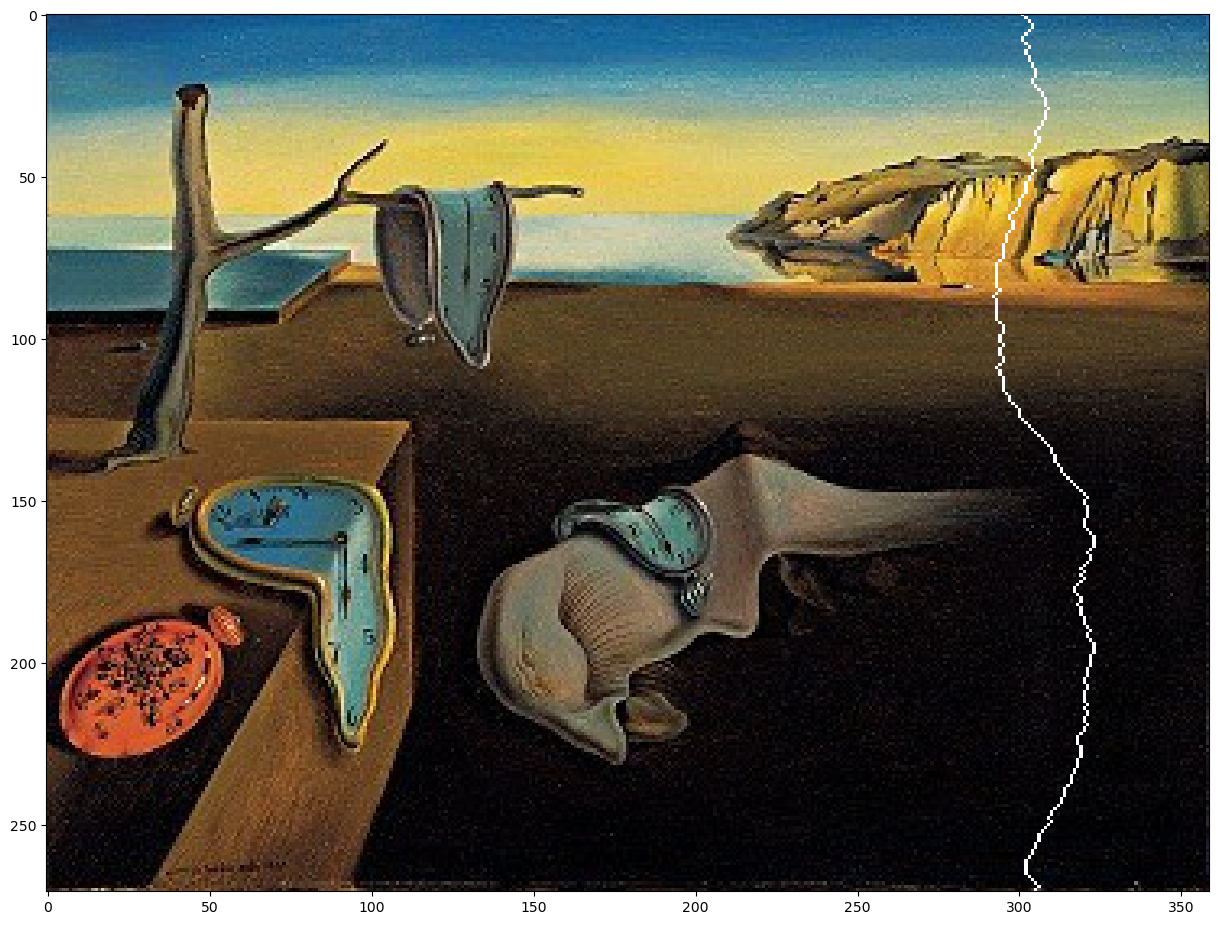

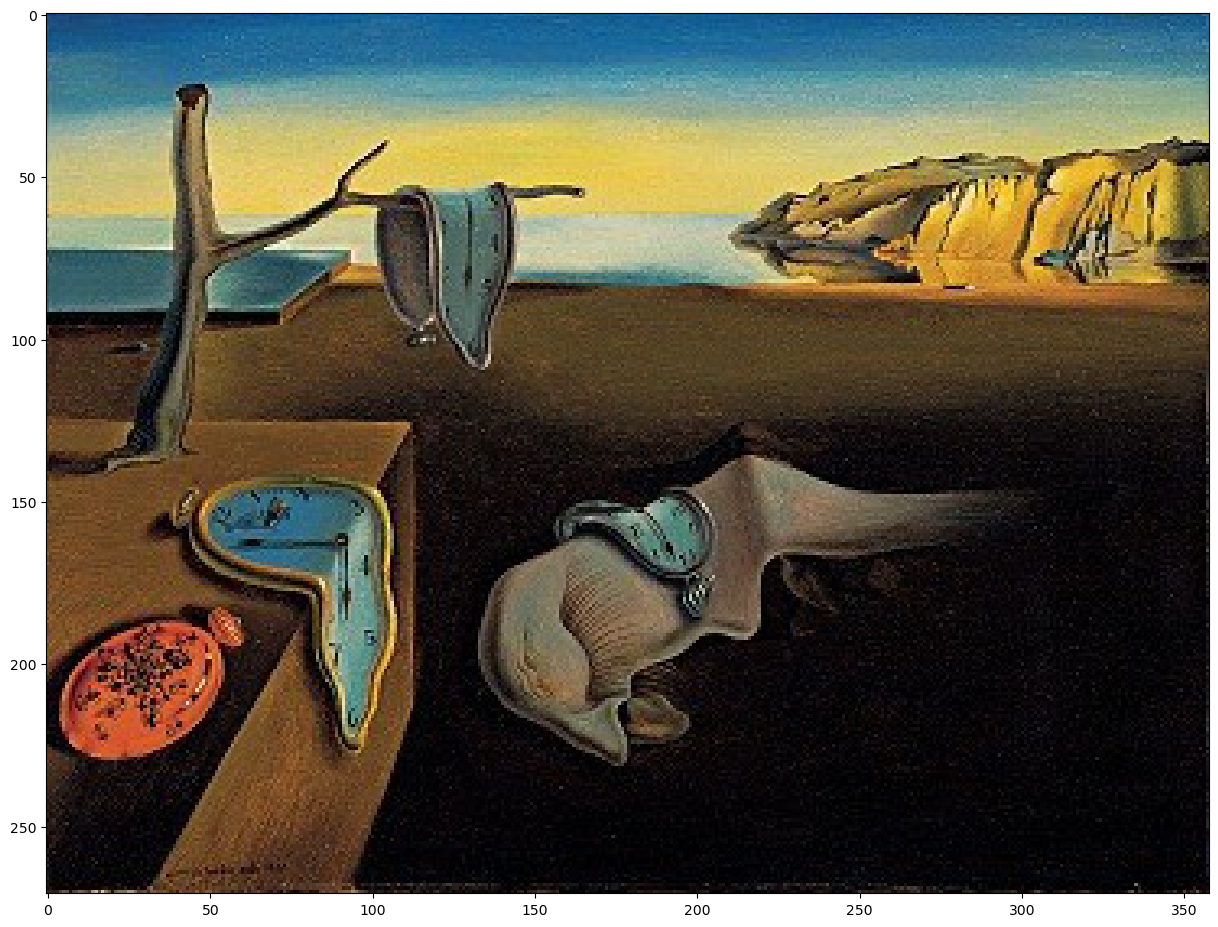

In [19]:
N = 10
origImg = img
origGreyImg = GreyScale(origImg)
XImg = imageKernel(origGreyImg,sobelX)
YImg = imageKernel(origGreyImg,sobelY)
XYIMG = XImg + YImg
XYIMG = np.abs(XYIMG)
for i in range(N):
    ener = getEnergyMap(np.array(XYIMG))
    pathDEBUG = greedyPath(ener)
    if i == N-1:
        DEBUG_PrintImageWithPath(origImg,pathDEBUG)
    origImg = deletePath(origImg,pathDEBUG)
    XYIMG = deletePath(XYIMG,pathDEBUG)

plt.subplots(1, figsize=figsize)
plt.imshow(origImg,vmin = 0,vmax =1)